In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import mglearn
import warnings

warnings.filterwarnings('ignore') 
plt.style.use('classic')

# 특성자동선택 

## 일변량 통계 (ANOVA)
### feature를 각각 독립적이라 보고 feature 와 target 사이에 통계적 상관관계가 없다면
### 해당 feature를 제외시킨다.

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif

cancer = load_breast_cancer()

rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# 30개는 원본 데이터, 50개는 노이즈이다.
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target,
                                                    random_state=0, test_size=0.5)

select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

print("X_train shape : ", X_train.shape)
print("X_train_selected shape : ", X_train_selected.shape)

X_train shape :  (284, 80)
X_train_selected shape :  (284, 40)


In [13]:
# 어떤 특성을 선택했는지 확인

mask = select.get_support()
print(mask)

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


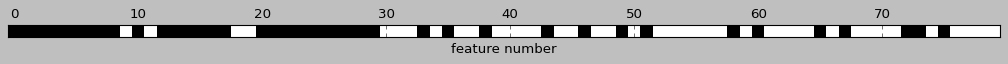

In [14]:
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel("feature number")
plt.yticks(())
plt.show()

In [15]:
# 잡음이 거의 제거된 것을 확인할 수 있다.
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(f"노이즈가 존재하는 전체 특성의 test score : {log.score(X_test, y_test):0.3f}")

log = LogisticRegression(max_iter=5000).fit(X_train_selected, y_train)
print(f"노이즈가 제거된 특성의 test score : {log.score(X_test_selected, y_test):0.3f}")

노이즈가 존재하는 전체 특성의 test score : 0.951
노이즈가 제거된 특성의 test score : 0.933


## 모델 기반 특성 선택
### 대부분의 모델이 특성관의 상관관계를 예측에 활용하기 때문에 일변량 통계와는 다르게 특성을 선택하는데 있어서 특성 간 상관관계도 고려한다.

In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# threshold는 임계치로 default는 mean이다. 위의 일변량 통계와 비교하기 위해 중간값이 median 을 사용한다.
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                         threshold="median")

In [17]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
X_test_l1 = select.transform(X_test)
print("X_train.shape : ", X_train.shape)
print("X_train_l1.shape : ", X_train_l1.shape)

X_train.shape :  (284, 80)
X_train_l1.shape :  (284, 40)


([], [])

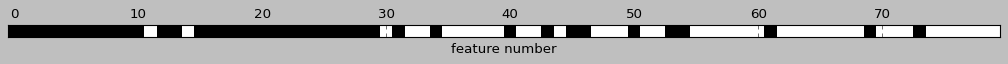

In [18]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel("feature number")
plt.yticks(())

In [19]:
log = LogisticRegression(max_iter=5000).fit(X_train_l1, y_train)
print(f"노이즈가 제거된 특성의 test score : {log.score(X_test_l1, y_test):0.3f}")

노이즈가 제거된 특성의 test score : 0.947


## 반복적 특성 선택
1. 전진선택법 : 0개의 특성에서 시작해서 중요도가 높은 순으로 특성을 선택하는 방법
2. 후진선택법 : 전체 특성에서 시작해서 중요도가 낮은 순으로 특성을 제거하는 방법

### 단점 : 계산 비용이 많이 든다.

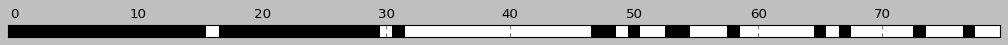

In [22]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.yticks(())
plt.show()

In [23]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

log = LogisticRegression(max_iter=5000).fit(X_train_rfe, y_train)

print(f"test score : {log.score(X_test_rfe, y_test):0.3f}")

test score : 0.940


In [35]:
citybike = mglearn.datasets.load_citibike()
citybike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3H, Name: one, Length: 248, dtype: int64

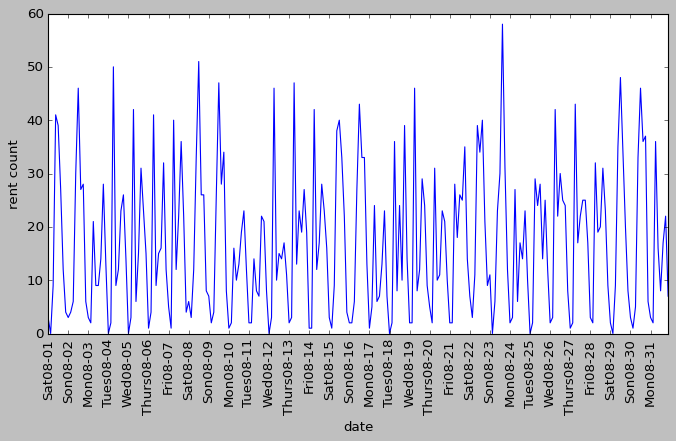

In [87]:
date_range = pd.date_range(citybike.index.min(), citybike.index.max(), freq='d')
week = ['Son','Mon','Tues','Wed','Thurs','Fri','Sat']
xticks = [week[int(date.strftime('%w'))] + date.strftime('%m-%d') for date in date_range]
plt.figure(figsize=(10,5))
# xticks를 pd.date type으로 두면 xticks에 포함되지 않은 date에 대해서도 그래프를 그릴 수 있다.
plt.xticks(date_range, xticks, rotation = 90)
plt.plot(citybike)
plt.xlabel("date")
plt.ylabel("rent count")
plt.show()

In [101]:
# date를 POSIX 시간으로 바꾼다.
y = citybike.values
X = citybike.index.astype('int64').values.reshape(-1,1)

n_train = 184
def eval_on_features(features, target, regressor) :
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print(f"test score : {regressor.score(X_test, y_test):0.3f}")
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    plt.figure(figsize=(10,5))
    plt.xticks(range(0,len(X),8), xticks, rotation=90)
    plt.plot(range(n_train), y_train, label='train', lw=3)
    plt.plot(range(n_train), y_train_pred, label='train predicted', ls='--', lw=3)
    plt.plot(range(n_train, len(X)), y_test, label='test',lw=3)
    plt.plot(range(n_train, len(X)), y_test_pred, label='test predicted', ls='--',lw=3)
    plt.legend(loc=(1.01,0))
    plt.xlabel("date")
    plt.ylabel("rent count")
    plt.show()

test score : -0.175


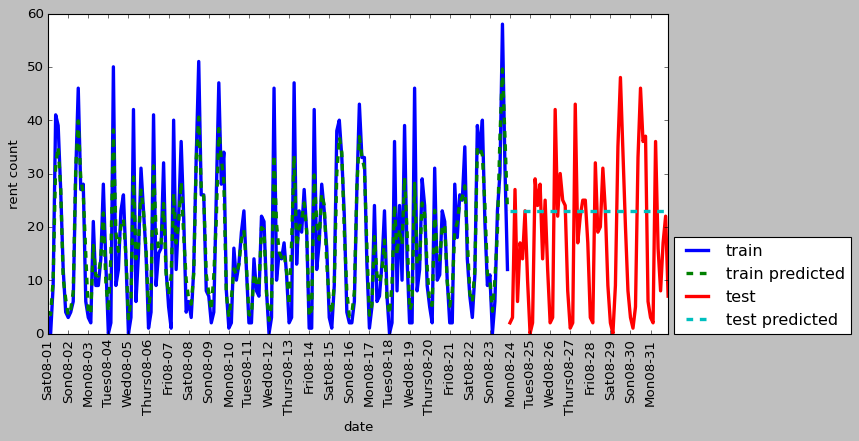

In [102]:
# 랜덤포레스트는 외삽에 대해서는 예측을 하지 못한다.
from sklearn.ensemble import RandomForestRegressor
eval_on_features(X,y,RandomForestRegressor())

test score : 0.595


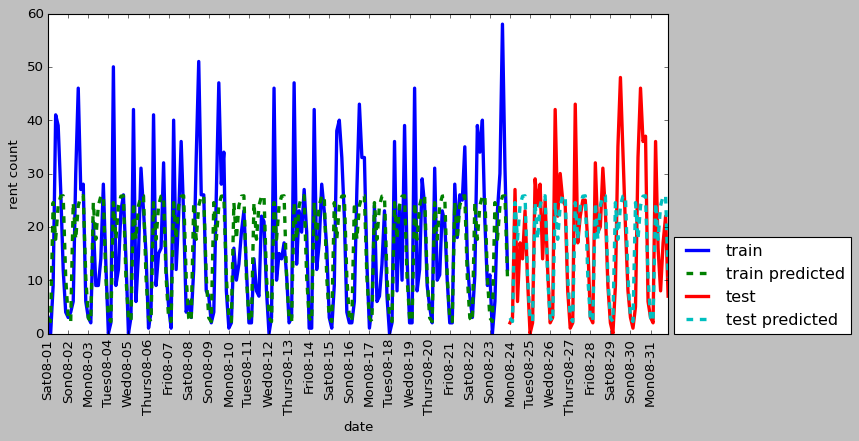

In [105]:
# 각각의 시간데이터로 학습시킨다.
X_hour = citybike.index.hour.values.reshape(-1,1)
eval_on_features(X_hour, y, RandomForestRegressor())

test score : 0.842


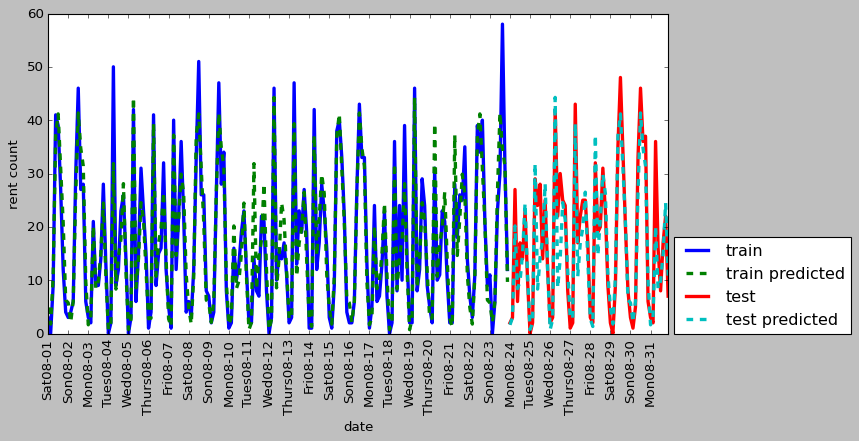

In [107]:
# 시간 데이터와 주말 데이터를 결합한 값으로 학습시킨다.
X_hour_week = np.hstack([citybike.index.dayofweek.values.reshape(-1,1), X_hour])
eval_on_features(X_hour_week, y, RandomForestRegressor())

test score : 0.625


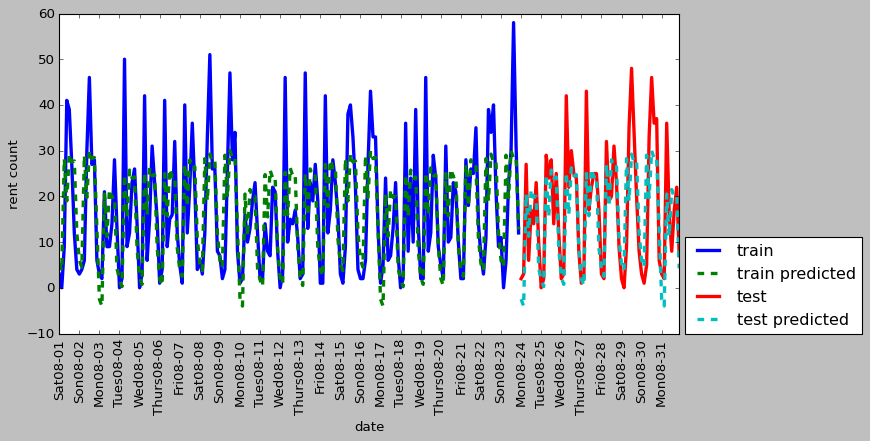

In [113]:
# 선형함수를 이용하는 경우
# hour과 week 데이터 모두 연속형 데이터가 아닌 범주형 데이터이므로 onehotencoder를 활용한다.

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
X_hour_week_onehot = OneHotEncoder().fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, LinearRegression())

test score : 0.838


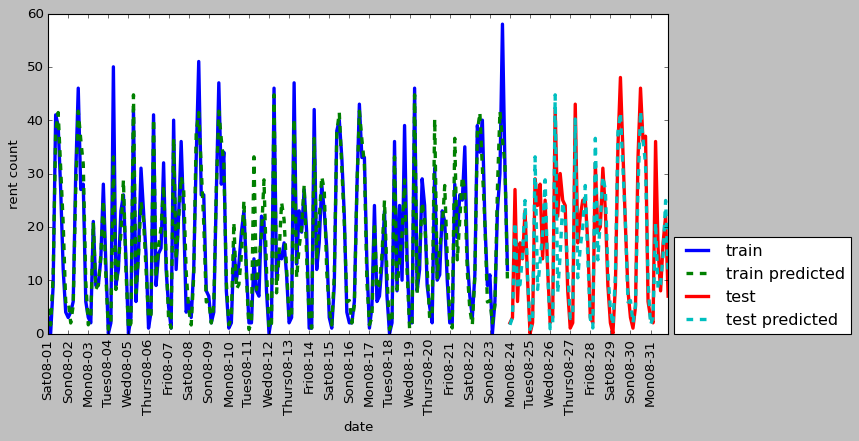

In [119]:
# 요일과 시간은 자전거 렌트 수를 결정하는데 있어서 서로 무관하지 않다.
from sklearn.preprocessing import PolynomialFeatures
# interaction_only 은 중복조합에서 자기 자신을 중복으로 뽑는 경우를 포함시키는지 여부이다.
# include_bias 는 0차항을 포함하는지 여부이다.
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly.fit_transform(X_hour_week_onehot)
eval_on_features(X_hour_week_onehot_poly, y, LinearRegression())

test score : 0.845


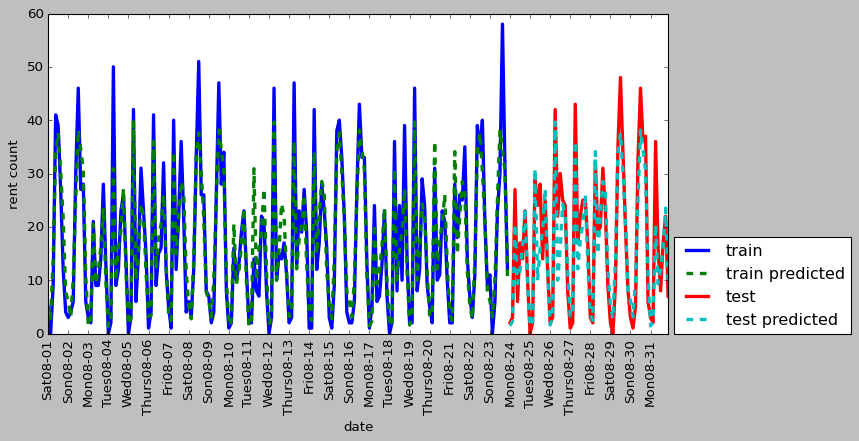

In [120]:
from sklearn.linear_model import Ridge
eval_on_features(X_hour_week_onehot_poly, y, Ridge())